## Final Dataset Ready

In [1]:
# Step 0. Import libraries, custom modules and logging
import joblib
import logging
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             r2_score,
                             root_mean_squared_error)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (OneHotEncoder,
                                   MinMaxScaler,
                                  )
from sklearn.inspection import permutation_importance
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [32]:
# 1. Create dataframe
df_raw = pd.read_csv('datasets/dataset_ig_stories.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hora_de_publicacion     371 non-null    object 
 1   descripcion             181 non-null    object 
 2   alcance                 345 non-null    float64
 3   me_gusta                371 non-null    int64  
 4   veces_que_se_compartio  371 non-null    int64  
 5   visitas_al_perfil       289 non-null    float64
 6   respuestas              371 non-null    int64  
 7   navegacion              344 non-null    float64
 8   clics_en_el_enlace      10 non-null     float64
 9   seguimientos            10 non-null     float64
 10  toques_en_stickers      16 non-null     float64
 11  visualizaciones         85 non-null     float64
 12  sentimiento_score       371 non-null    int64  
 13  fecha                   371 non-null    object 
 14  nombre_archivo          371 non-null    ob

In [33]:
df_raw.sample(10, random_state=2024)

,hora_de_publicacion,descripcion,alcance,me_gusta,veces_que_se_compartio,visitas_al_perfil,respuestas,navegacion,clics_en_el_enlace,seguimientos,toques_en_stickers,visualizaciones,sentimiento_score,fecha,nombre_archivo,objeto_principal,color_dominante,emocion_primaria,categoria
131,03/09/2023 09:41,NaN,171.0,0,0,NaN,0,157.0,NaN,NaN,NaN,NaN,-2,03/09/2023,img_20230903_104252_723.JPG,manequin,#7d7691,happy,"Selfie, Sticker"
198,03/01/2024 06:00,NaN,512.0,5,1,8.0,0,532.0,NaN,NaN,NaN,NaN,-2,03/01/2024,IMG_20240103_091845_420.jpg,person,#e1886a,surprise,"Otro, Cuerpo Completo"
347,04/12/2024 14:24,"Hoy agradezco ser mamá, aún con todo lo difíci...",8147.0,7,0,51.0,0,7999.0,NaN,NaN,NaN,8307.0,0,04/12/2024,IMG_20241204_162420_929.jpg,people,#7b6089,happy,Con otras personas
201,05/01/2024 12:08,NaN,368.0,3,0,4.0,0,373.0,NaN,NaN,NaN,NaN,-2,05/01/2024,IMG_20240105_140833_389.jpg,person,#4c3228,sad,"Cuerpo Completo, Sticker"
269,04/05/2024 15:13,NaN,1068.0,2,0,9.0,1,1082.0,NaN,NaN,NaN,NaN,-2,04/05/2024,IMG_20240504_161357_968.jpg,people,#6e647e,happy,Otro
307,31/08/2024 11:01,¡Sábado social!,7416.0,10,0,54.0,0,7791.0,NaN,1.0,NaN,7568.0,0,31/08/2024,IMG_20240831_120114_836.jpg,sunglasses,#6f7c7d,happy,Selfie
38,06/03/2023 09:48,NaN,1193.0,6,0,7.0,0,1196.0,NaN,NaN,NaN,NaN,-2,06/03/2023,IMG_20230306_114921_701.jpg,oracle,#9ca993,happy,"Otro, Sticker"
303,28/08/2024 10:54,NaN,2859.0,8,0,8.0,0,2879.0,NaN,NaN,NaN,2929.0,-2,28/08/2024,IMG_20240828_115454_915.jpg,skeleton,#9dc6c0,happy,"Sticker, Reposteo"
308,01/09/2024 10:39,¡No podía faltar \nMi platillo \nfavorito!,299.0,1,0,1.0,0,290.0,NaN,NaN,NaN,305.0,0,01/09/2024,IMG_20240901_113918_911.jpg,banjo,#687779,neutral,Otro
179,08/12/2023 07:40,¡Gracias a quienes asistieron al webinar ayer!,627.0,1,0,2.0,1,614.0,NaN,NaN,NaN,NaN,0,08/12/2023,img_20231208_094046_142.JPG,web_site,#c9b0a9,fear,Comida y Bebida


In [34]:
print(df_raw.columns)


Index(['hora_de_publicacion', 'descripcion', 'alcance', 'me_gusta',
       'veces_que_se_compartio', 'visitas_al_perfil', 'respuestas',
       'navegacion', 'clics_en_el_enlace', 'seguimientos',
       'toques_en_stickers', 'visualizaciones', 'sentimiento_score', 'fecha',
       'nombre_archivo', 'objeto_principal', 'color_dominante',
       'emocion_primaria', 'categoria'],
      dtype='object')


In [35]:
df_raw.columns = df_raw.columns.str.strip()  # Esto quita espacios en blanco al principio y al final

**Data Dictionary**

In [36]:
#Step 2. Prepare the dataset for analysis
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ', '_')
        .str.replace(r'\W', '', regex=True)
        .str.lower()
        .str.slice(0, 40),
        axis=1
    )
    .dropna(subset=['alcance'])
    .rename(columns={'alcance': 'target'})
    .iloc[:, 1:]
    .drop(
        ["descripcion", "hora_de_publicacion", "visualizaciones", 
         "fecha", "nombre_archivo", "clics_en_el_enlace", 
         "seguimientos", "me_gusta", "veces_que_se_compartio", "respuestas", "toques_en_stickers"], 
        axis=1, errors='ignore'
    )
      .astype({"categoria": "category", "objeto_principal": "category", "color_dominante": "category", "emocion_primaria": "category", "sentimiento_score": "category"})


)
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345 entries, 26 to 370
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   target             345 non-null    float64 
 1   visitas_al_perfil  289 non-null    float64 
 2   navegacion         344 non-null    float64 
 3   sentimiento_score  345 non-null    category
 4   objeto_principal   345 non-null    category
 5   color_dominante    345 non-null    category
 6   emocion_primaria   345 non-null    category
 7   categoria          345 non-null    category
dtypes: category(5), float64(3)
memory usage: 31.5 KB


In [37]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] +
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345 entries, 26 to 370
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   target             345 non-null    float64 
 1   visitas_al_perfil  289 non-null    float64 
 2   navegacion         344 non-null    float64 
 3   sentimiento_score  345 non-null    category
 4   objeto_principal   345 non-null    category
 5   color_dominante    345 non-null    category
 6   emocion_primaria   345 non-null    category
 7   categoria          345 non-null    category
dtypes: category(5), float64(3)
memory usage: 31.5 KB


In [38]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df,
                                     random_state=2024,
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 101 to 108
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   target             276 non-null    float64 
 1   visitas_al_perfil  232 non-null    float64 
 2   navegacion         276 non-null    float64 
 3   sentimiento_score  276 non-null    category
 4   objeto_principal   276 non-null    category
 5   color_dominante    276 non-null    category
 6   emocion_primaria   276 non-null    category
 7   categoria          276 non-null    category
dtypes: category(5), float64(3)
memory usage: 28.9 KB


In [39]:
# 3.2 Show descriptive statistics
display(df_train.describe(include='category').T)
display(df_train.describe().T)

,count,unique,top,freq
sentimiento_score,276,2,-2,143
objeto_principal,276,88,person,45
color_dominante,276,275,#793056,2
emocion_primaria,276,9,happy,155
categoria,276,49,Selfie,34


,count,mean,std,min,25%,50%,75%,max
target,276.0,1632.336957,2564.274946,109.0,337.5,650.5,1392.50,21867.0
visitas_al_perfil,232.0,12.995690,32.266007,1.0,2.0,6.0,12.00,445.0
navegacion,276.0,1635.768116,2596.364615,113.0,329.5,661.5,1389.75,23058.0


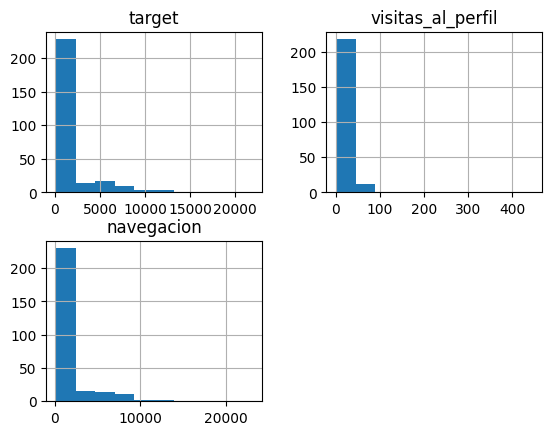

In [40]:
# 3.3 Univariate analysis - numerical features
df_train.hist()
plt.show()

<Axes: xlabel='navegacion'>

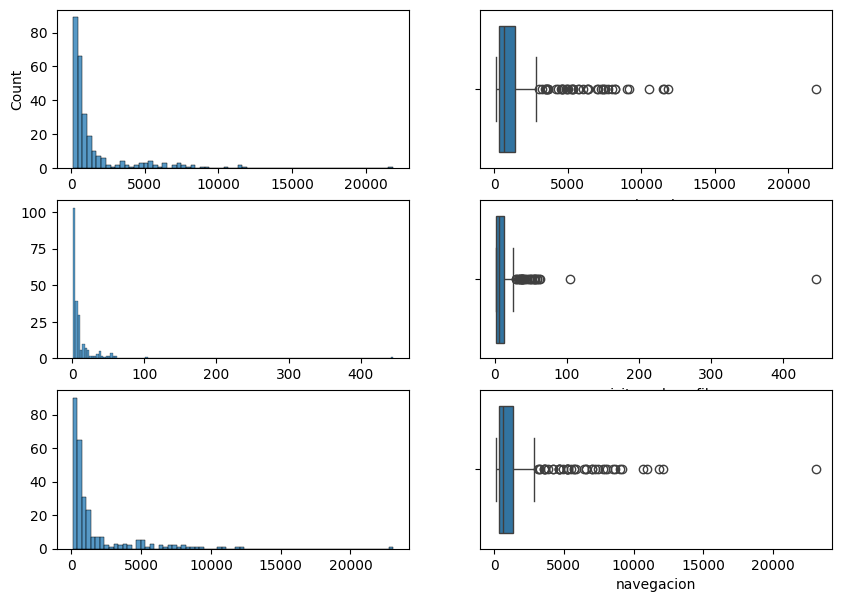

In [41]:
# 3.4 Outlier detection
fig, axis = plt.subplots(3, 2, figsize = (10, 7))
sns.histplot(ax = axis[0, 0], data = df_train, x= "target").set(xlabel = None)
sns.boxplot(ax = axis[0, 1], data = df_train, x = "target")
sns.histplot(ax = axis[1, 0], data = df_train, x = "visitas_al_perfil").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = df_train, x = "visitas_al_perfil")
sns.histplot(ax = axis[2, 0], data = df_train, x = "navegacion").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[2, 1], data = df_train, x = "navegacion")

I will evaluate the following models:
Random Forest
Gradient Boosting
LightGMB